In [190]:
import numpy as np
import matplotlib.pyplot as plt

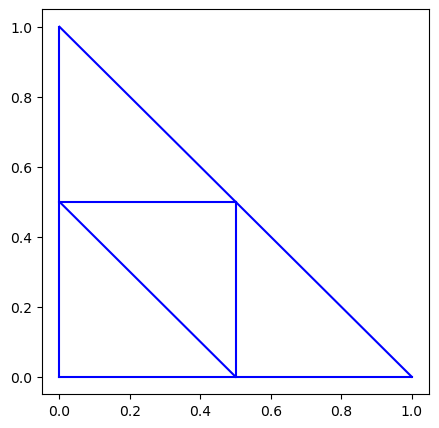

In [191]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([0, 0], [0, 1], color='blue')
plt.plot([1, 0], [0, 0], color='blue')
plt.plot([1/2, 1/2], [0, 1/2], color='blue')
plt.plot([0, 1/2], [1/2, 1/2], color='blue')
plt.plot([0, 1/2], [1/2, 0], color='blue')
plt.plot([0, 1], [1, 0], color='blue')
plt.show()

In [1]:

# 求解区域的范围
x_range = [0.0, 1.0]
y_range = [0.0, 1.0]

# 划分的步长
h = 0.01

# 每一个点的坐标
x = np.arange(x_range[0], x_range[1]+h, h)
y = np.arange(y_range[0], y_range[1]+h, h)
#print(x)
# 格点数目
x_n_grid = len(x)
y_n_grid = len(y)
#print(x_n_grid)
# 边界点和求解区域，边界点标记为True，待求点标记为False
area = []
for i in range(x_n_grid):
    #print(i)
    area.append(np.zeros(x_n_grid-i))
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if (i==0)or(j==0)or(i*h+j*h == 1):
            area[i][j] = 1
        
#print(area)

NameError: name 'np' is not defined

In [193]:
# 建立编号矩阵，其中的每一个编号对应区域中的一个节点
index_matrix = []
k = 0
for i in range(x_n_grid):
    #print(i)
    index_matrix.append(np.zeros(x_n_grid-i,dtype=int))
    
# 先对内部节点编号
for i in range(x_n_grid):
    for j in range(y_n_grid-i):
        if not area[i][j]:
            index_matrix[i][j] = k
            k += 1
            
# 内部节点数            
n_inner = k

# 然后对边界节点编号
for i in range(x_n_grid):
    for j in range(y_n_grid-i):
        if area[i][j]:
            index_matrix[i][j] = k
            k += 1

# 边界节点数        
n_edge = k - n_inner
          
#print(index_matrix)

In [194]:
class element:
    def __init__(self, index_list, x_list, y_list):
        # 记录三角形元素的三个节点编号和坐标
        self.index = index_list
        self.x = x_list
        self.y = y_list
        # 计算三角形元素的b和c
        self.b = [self.y[(i+1)%3]-self.y[(i+2)%3] for i in range(3)]
        self.c = [self.x[(i+2)%3]-self.x[(i+1)%3] for i in range(3)]

e_list = []

for i in range(x_n_grid-1):
    for j in range(1, x_n_grid-i):
        #print(i,j)
        e_list.append(
            element(
                index_list=[index_matrix[i][j], index_matrix[i][j-1], index_matrix[i+1][j-1]],
                x_list=[x[i], x[i], x[i+1]],
                y_list=[y[j], y[j-1], y[j-1]]
            )
        )
        if (i+j+1<=x_n_grid-1):
            
            e_list.append(
                element(
                    index_list=[index_matrix[i][j], index_matrix[i+1][j-1], index_matrix[i+1][j]],
                    x_list=[x[i], x[i+1], x[i+1]],
                    y_list=[y[j], y[j-1], y[j]]
                )
            )
print(len(e_list))

10000


In [195]:
Delta = (x_range[1] - x_range[0])*(y_range[1] - y_range[0])/len(e_list)/2

K = np.zeros((n_inner + n_edge, n_inner + n_edge))

for e in e_list:
    for i in range(3):
        for j in range(i,3):
            K[e.index[i], e.index[j]] += (e.b[i]*e.b[j] + e.c[i]*e.c[j])/4/Delta
# 根据对称性补全K矩阵
K += K.T - np.diag(np.diag(K))
print(K)

[[ 4.  -1.   0.  ...  0.   0.   0. ]
 [-1.   4.  -1.  ...  0.   0.   0. ]
 [ 0.  -1.   4.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.  -1.  -0.5]
 [ 0.   0.   0.  ... -1.   2.   0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]]


In [196]:
#边界条件（题目有问题吧，在（1，0）（0，0）处条件矛盾
K_11 = K[:n_inner, :n_inner]
K_12 = K[:n_inner, n_inner:]
Phi_2 = np.ones((n_edge,1))
for i in range(x_n_grid-1):
    #print(x_n_grid+2*i)
    Phi_2[x_n_grid+2*i] = [0]
Phi_2[0]=[0]
#print(Phi_2)

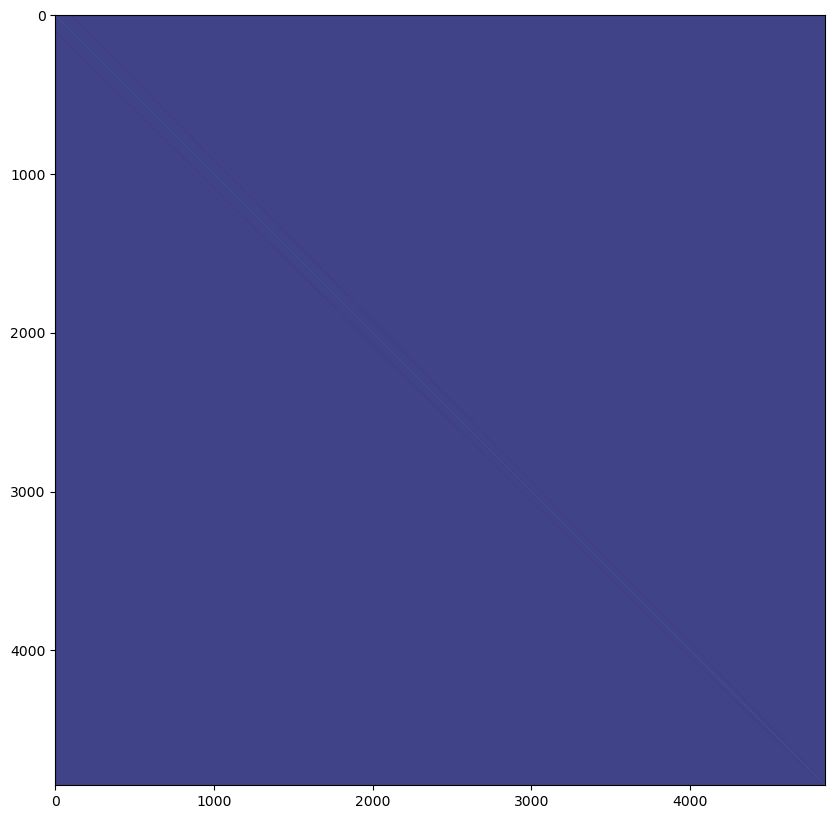

In [197]:
A = K_11
b = -K_12.dot(Phi_2)

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(A)
plt.show()

In [198]:
# 上面的公式中，大部分k_ij都等于0
# 只需要计算k_ij不为0的部分
# 因此先记录k_ij不为0的编号
k_ij_index = []
for i in range(n_inner):
    k_ij_index.append([])
    for j in range(n_inner+n_edge):
        if K[i, j] != 0 and i != j:
            k_ij_index[-1].append(j)
            
omega = 1.5

# 迭代初值，包含内部节点和边界节点
# 在矩阵运算中Phi是一个列向量
# 在迭代公式中，使用行向量更加简单
# 所以使用行向量记录Phi的每一个值
X = np.hstack((np.ones(n_inner), Phi_2.T[0]))
X0 = X.copy()

# 迭代时只改变内部节点
for i in range(n_inner):
    X[i] = (1-omega)*X[i]
    a = omega/K[i, i]
    for j in k_ij_index[i]:
        X[i] -= a*K[i, j]*X[j]

m = 1

while np.max(abs(X-X0)) > 1e-6:
    X0 = X.copy()
    for i in range(n_inner):
        X[i] = (1-omega)*X[i]
        a = omega/K[i, i]
        for j in k_ij_index[i]:
            X[i] -= a*K[i, j]*X[j]
    m += 1
    
print("Converges in %d steps"%m)

Converges in 1096 steps


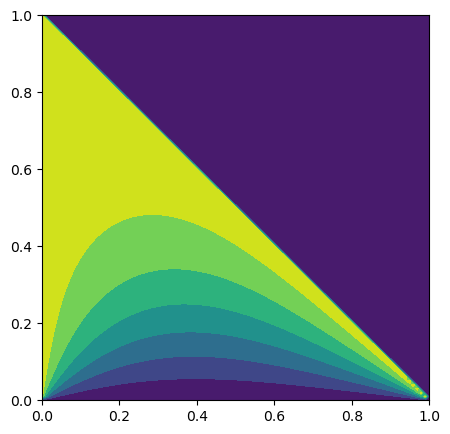

In [199]:
Phi = X.copy()

value_matrix = np.zeros((x_n_grid, y_n_grid))

# 将解填入求解区域中
for i in range(x_n_grid):
    for j in range(y_n_grid-i):
        value_matrix[i, j] = Phi[index_matrix[i][j]]

fig = plt.figure(figsize=(5, 5), dpi=100)
plt.contourf(x, y, value_matrix.T)
plt.show()